<a href="https://colab.research.google.com/github/18521527/Classification-Food-Transfer-SIFT-/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mounting Google Drive


In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the libraries

In [2]:
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import optimizers, losses, activations, models
import pathlib
import shutil
from keras.models import Model

In [3]:
import cv2

# Get data:

In [4]:
def get_data():
    if 'Dataset' in os.listdir():
        print('Dataset already exists')
    else:
        # print('Downloading the data...')
        # !gdown --id 1WBhCaHNG0Uh20MNsV3l9kjVXqzFilBQL
        # print('Dataset downloaded!')
        # print('Copying Zip file to your Drive..')
        # !cp /content/split-VietnameseFoods-30.tar.gz 'drive/My Drive/VietnameseFoods-30'
        # print('Copying done!')
        print('Copying the data...')
        !cp /content/drive/MyDrive/DeepLearning/Final/Model_Transfer/InceptionV3/split-mini-VietnameseFoods-30.tar.gz ./
        print('Dataset copied!')
        print('Extracting data..')
        !tar -xzvf split-mini-VietnameseFoods-30.tar.gz
        print('Extraction done!')
        print('Removing Zip file...')
        #os.remove('./split-VietnameseFoods-30.tar.gz')
        print('Done!')


get_data()

Dataset already exists


In [5]:
shutil.rmtree('/content/Dataset/Training dataset/Bánh đúc')

FileNotFoundError: ignored

In [ ]:
shutil.rmtree('/content/Dataset/Test dataset/Bánh đúc')
shutil.rmtree('/content/Dataset/Validation dataset/Bánh đúc')

# Read data

In [6]:
train_dir = './Dataset/Training dataset'
val_dir = './Dataset/Validation dataset'
test_dir = './Dataset/Test dataset'
BATCH_SIZE = 64
IMG_SIZE = (224, 224)


In [7]:
def prepare_data(train_dir, val_dir, test_dir, BATCH_SIZE, IMG_SIZE):
    train_datagen = image.ImageDataGenerator(rescale=1. / 255)
    valid_datagen = image.ImageDataGenerator(rescale=1. / 255)
    test_datagen = image.ImageDataGenerator(rescale=1. / 255)

    print('\nPreparing train dataset')
    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE)
    print('\nPreparing validation dataset')
    val_generator = valid_datagen.flow_from_directory(
        val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE)
    print('\nPreparing test dataset')
    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE)
    print('\nDone!')
    return train_generator, val_generator, test_generator


train_generator, val_generator, test_generator = prepare_data(
    train_dir, val_dir, test_dir, BATCH_SIZE, IMG_SIZE)


Preparing train dataset
Found 3420 images belonging to 29 classes.

Preparing validation dataset
Found 495 images belonging to 29 classes.

Preparing test dataset
Found 991 images belonging to 29 classes.

Done!


In [8]:
nb_classes = 29
nb_training_samples = 3420
nb_validation_samples = 495
nb_test_samples = 991

initial_epochs = 30
#total_epochs = initial_epochs + fine_tune_epochs
#fine_tune_at = 12

In [9]:
initial_epochs = 30

In [10]:
path = '/content/drive/MyDrive/DeepLearning/Final/Model_Transfer/InceptionV3'
best_base_model = os.path.join(path, 'best_base_model.hdf5')
base_log = os.path.join(path, 'base_history.log')
base_model_trained = os.path.join(path, 'base_model_trained.hdf5')
base_fig = os.path.join(path, 'base_fig.jpg')
best_fine_tune_model = os.path.join(path, 'best_fine_tune_model.hdf5')
fine_tune_log = os.path.join(path, 'fine_tune_history.log')
fine_tune_model_trained = os.path.join(path, 'fine_tune_model_trained.hdf5')
fine_tune_fig = os.path.join(path, 'fine_tune_fig.jpg')

In [11]:
'''
instantiate a base model with pre-trained weights
'''
print('\nInstantiating a base model with pre-trained weights..')
base_model = keras.applications.vgg19.VGG19(
    weights= 'imagenet', include_top=False)

'''
create a new model on top
'''
print('\nCreating a new model on top..')
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
predictions = keras.layers.Dense(
    nb_classes, kernel_regularizer=keras.regularizers.l2(0.005), activation='softmax')(x)
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False
'''
compile the model
'''
print('\nCompiling the model..')
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])

base_checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=best_base_model, verbose=1, save_best_only=True)
base_csv_logger = keras.callbacks.CSVLogger(base_log)

'''
train the model on new data
'''
print('\nTraining the model on new data..')
history = model.fit(train_generator,
                    steps_per_epoch=nb_training_samples // BATCH_SIZE,
                    validation_data=val_generator,
                    validation_steps=nb_validation_samples // BATCH_SIZE,
                    epochs=initial_epochs,
                    verbose=1,
                    callbacks=[base_csv_logger, base_checkpointer])
'''
save the model
'''
print('\nSaving the model..')
model.save(base_model_trained)

print('\nDone!')



Instantiating a base model with pre-trained weights..

Creating a new model on top..

Compiling the model..

Training the model on new data..
Epoch 1/30
53/53 [==============================] - 72s 1s/step - loss: 3.5277 - accuracy: 0.0907 - val_loss: 3.0674 - val_accuracy: 0.2009

Epoch 00001: val_loss improved from inf to 3.06742, saving model to /content/drive/MyDrive/DeepLearning/Final/Model_Transfer/InceptionV3/best_base_model.hdf5
Epoch 2/30
53/53 [==============================] - 66s 1s/step - loss: 2.9541 - accuracy: 0.2194 - val_loss: 2.7678 - val_accuracy: 0.2143

Epoch 00002: val_loss improved from 3.06742 to 2.76783, saving model to /content/drive/MyDrive/DeepLearning/Final/Model_Transfer/InceptionV3/best_base_model.hdf5
Epoch 3/30
53/53 [==============================] - 66s 1s/step - loss: 2.7395 - accuracy: 0.2597 - val_loss: 2.5903 - val_accuracy: 0.2991

Epoch 00003: val_loss improved from 2.76783 to 2.59035, saving model to /content/drive/MyDrive/DeepLearning/Final/

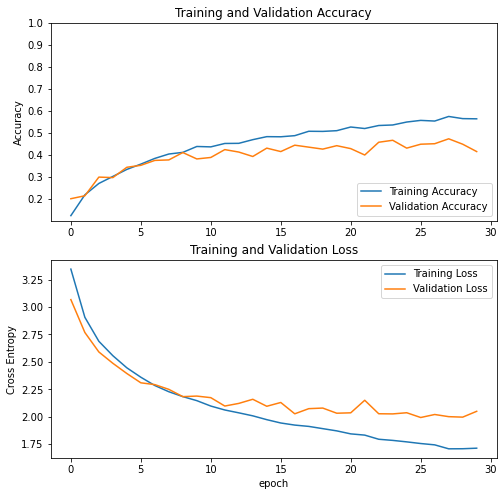

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(base_fig)
plt.show()

In [13]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy:', accuracy)

16/16 [==============================] - 19s 1s/step - loss: 2.0885 - accuracy: 0.4339
Test accuracy: 0.43390515446662903
